## 离散空间下机器人路径规划的遗传算法

浙江大学 数学科学学院
Zhejiang University, School of Mathemtical Sciences

肖特嗣
Tesi Xiao

In [1]:
%matplotlib inline
from math import sqrt
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio,os

### 如何表示一个网格？

#### Grid类：

- 属性：长、宽、障碍栅格序号

（可视化栅格的表示，0表示障碍栅格，1表示自由栅格）

- 方法：
 + show()： 可视化栅格
 + dist_btw_points(p1, p2)：计算给定序号两点的距离
 + idx_to_coordinate(p)： 计算给定序号点的坐标
 + coordinate_to_idx(x, y)：计算给定坐标的点的序号

In [2]:
class Grid:
    __slots__ = ('__length', '__width', '__b_cells')
    
    def __init__(self, length, width, num_b_cell):
        """
        Randomly initialize a Grid object with specified length, width and number of barrier cells
        :length: 
        :width:
        :num_b_cell:(private) number of barrier cells
        """
        b_cells = np.random.choice(range(1,length*width-1), num_b_cell)
        
        self.__length = length
        self.__width = width
        self.__b_cells = b_cells
    
    def set_b_cells(self, b_cells):
        """
        Set the indexes of barrier cellsw
        :b_cells: an array of indexes of barrier cells
        """
        self.__b_cells = b_cells
    
    @property
    def values(self):
        grid = np.ones((self.__length,self.__width), dtype=int)
        for i in self.__b_cells:
            grid.itemset(i, 0)
        return grid
    
    @property
    def b_cells(self):
        return self.__b_cells
    
    @property
    def size(self):
        return self.__length * self.__width
    
    @property
    def length(self):
        return self.__length
    
    @property
    def width(self):
        return self.__width
    
    def idx_to_coordinate(self, p):
        x = p % self.__width
        y = p // self.__width
        return x, y
    
    def coordinate_to_idx(self, x, y):
        idx = y*self.__width + x
        return idx
    
    def dist_btw_points(self, p1, p2):
        p1_x, p1_y = self.idx_to_coordinate(p1)
        p2_x, p2_y = self.idx_to_coordinate(p2)
        return sum(np.sqrt([(p1_x-p2_x)**2+(p1_y-p2_y)**2]))
    
    def show(self):
        l = self.__length
        w = self.__width
        plt.figure(figsize=(15,15))
        plt.imshow(self.values, cmap='gray')
        ax = plt.gca()

        # Major ticks
        ax.set_xticks(np.arange(0, w, 1))
        ax.set_yticks(np.arange(0, l, 1))

        # Labels for major ticks
        ax.set_xticklabels(np.arange(0, w, 1))
        ax.set_yticklabels(np.arange(0, l, 1))
        
        # Minor ticks
        ax.set_xticks(np.arange(-.5, w, 1), minor=True)
        ax.set_yticks(np.arange(-.5, l, 1), minor=True)

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1.5)
        
        for idx in range(self.size):
            x, y = self.idx_to_coordinate(idx)
            ax.text(x-0.1, y+0.1, idx, fontsize=10)

生成书上的几个10乘10的网格

In [3]:
G1 = Grid(10,10,20)
b_cells = {1:[3, 9, 10, 12, 13, 16, 26, 31, 32, 41, 42, 48, 56, 63, 69, 76, 77, 81, 86, 91, 94],
           2:[3, 9, 10, 12, 13, 16, 26, 31, 32, 34, 41, 42, 44, 46, 48, 54, 56, 63, 64, 66, 69, 76, 77, 81, 86, 91, 94],
           3:[3, 9, 10, 12, 13, 16, 26, 31, 32, 34, 36, 41, 42, 44, 46, 48, 54, 56, 61, 63, 64,
              66, 69, 76, 77, 81, 84, 85, 86, 91],
          }
G1.set_b_cells(b_cells[1])

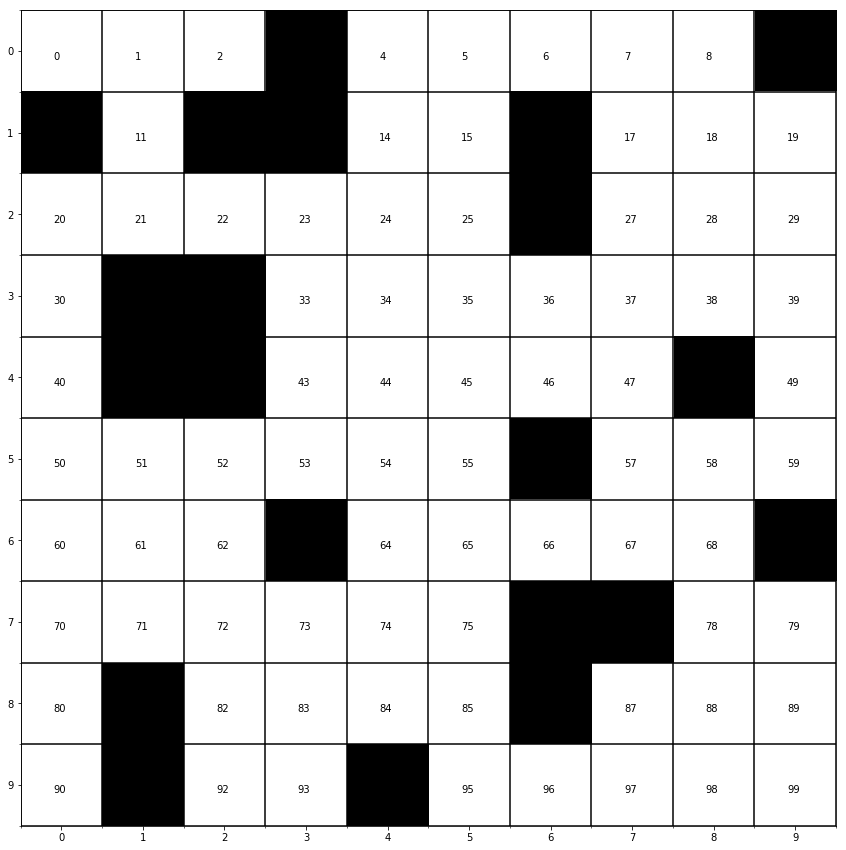

In [4]:
G1.show()

生成一个更复杂的20乘20的网格

In [5]:
G2 = Grid(20,20,150)
b_cells = {1:[2,6, 13, 14, 24, 28, 37, 41, 42, 44, 45, 48, 51, 56, 57, 58, 70, 71, 73, 86, 88, 89, 90, 93, 95, 96, 99,
              100, 104, 106, 118, 119, 120, 122, 124, 126, 128, 129, 132, 133, 134, 136, 140, 146,
              152, 156, 165, 166, 169, 170, 172, 183, 189, 192, 197,
              201, 202, 203, 205, 206, 208, 209, 219, 226, 227, 228, 232, 233, 235, 236, 243,
              250, 255, 260, 261, 263, 265, 285, 267, 274, 272, 275, 277, 278, 287, 288, 290, 292,
              302, 303, 310, 318, 319, 333, 336, 341, 347, 348, 
              350, 351, 353, 356, 361, 362, 363, 373, 374, 378, 385, 389, 390, 391]}
G2.set_b_cells(b_cells[1])

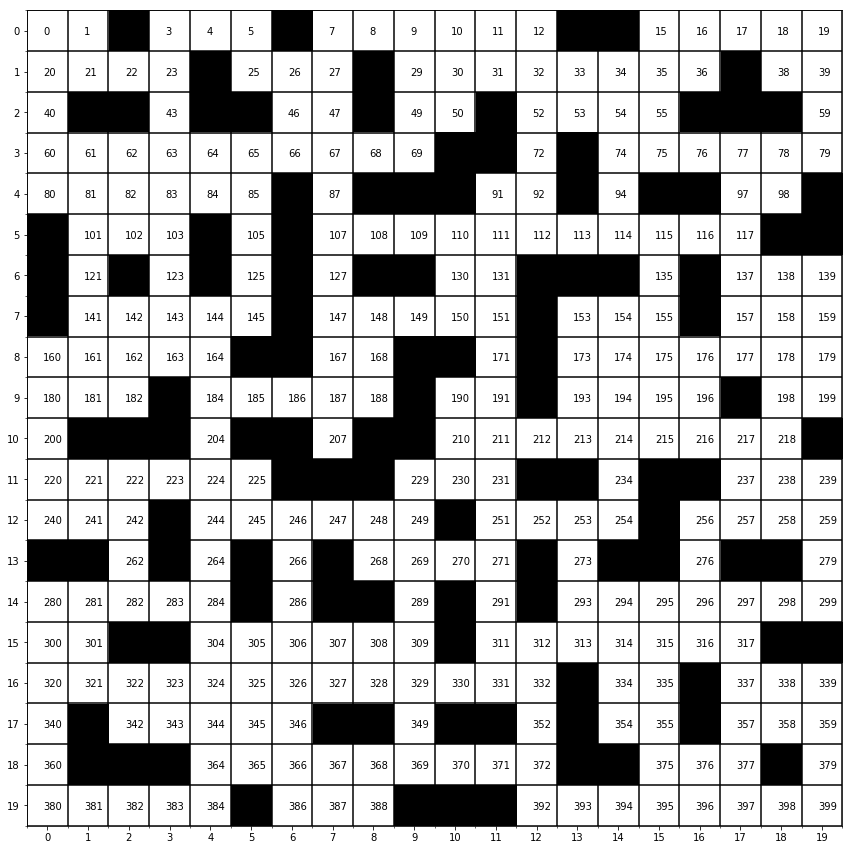

In [6]:
G2.show()

### 如何表示一条路径？

#### Individual 类：（路径类）

- 属性：
 + __grid ：所在网格
 + __start ： 起点
 + __end ： 终点
 + __path ：路径点
 
 
- 方法：
 + show(): 可视化路径
 + fitness_func(): 计算其适应度函数
 + inforamtion_report(): 给出该个体所有信息
 + is_continuous(): 判断是否为联通路径
 + mutation(): 变异操作
 + crossover(): 交叉操作
 + insertion(): 插入操作
 + adjust(): 修正操作
 
值得讨论的地方：
1. 变异算子：三种变异的概率
2. 插入算子（初始途径栅格数的选择，我这里选择为3）
3. 删除算子
4. 修正算子（我自己添加的，书上没有考虑到这个）

可以优化的地方：
1. 插入算子中选择终点的方式：给随机加一些偏向？
2. 缩短冗余的路径

In [23]:
class Individual:
    __slots__ = ('__path', '__grid', '__start', '__end')
    
    def __init__(self, grid, start, end, n_cells):
        """
        :grid: a Grid object
        :n_cells: number of passing cells
        """
        self.__grid = grid
        self.__start = start
        self.__end = end
        
        # initialize path randomly
        self.init_path(n_cells)
        # self.show()
        self.insertion()
        # self.show()
        self.adjust()
        # self.show()
        
    def init_path(self, n_cells):
        path = [self.__start]
        na_set = set(self.__grid.b_cells)
        na_set.add(self.__start)
        na_set.add(self.__end)
        a_set = set(np.arange(0,self.__grid.size)) - na_set
        sel_path = np.random.choice(list(a_set), n_cells-2)
        for p in sel_path:
            path.append(p)
        path.sort()
        path.append(self.__end)
        self.__path = path
    
    def set_path(self, path):
        self.__path = path
    
    @property
    def grid(self):
        return self.__grid
    
    @property
    def path(self):
        return self.__path
    
    @property
    def distance(self):
        dist = 0
        for d in zip(self.__path[:self.n_cells-1], self.__path[1:]):
            dist = dist + self.__grid.dist_btw_points(d[0],d[1])
        return dist
    
    @property
    def n_cells(self):
        return len(self.__path)
    
    def show(self):
        self.__grid.show()
        ax = plt.gca()
        x = []
        y = []
        for p in self.__path:
            px, py = self.__grid.idx_to_coordinate(p)
            x.append(px)
            y.append(py)
        ax.plot(x,y, 'ro-', linewidth=2)
    
    def information_report(self):
        print('Path: ', self.__path[0], end='')
        for p in self.__path[1:]:
            print('->', p, end='')
        print('\nn: ', self.n_cells)
        print('Distance:  ', self.distance)
        print('Fitness function: ', self.fitness_func())
        #self.show()
    
    def fitness_func(self):
        # return (1+1/sqrt(self.n_cells-1))*self.distance
        return self.distance
    
    def is_continuous(self):
        """
        :return: a tuple, (True/False, an index of discontinous point if False)
        """
        flag = True
        for idx in range(self.n_cells-1):
            p1 = self.__path[idx]
            p2 = self.__path[idx+1]
            p1_x, p1_y = self.__grid.idx_to_coordinate(p1)
            p2_x, p2_y = self.__grid.idx_to_coordinate(p2)
            delta = max(abs(p1_x-p2_x), abs(p1_y-p2_y))
            if delta > 1:
                flag = False
                break
        return flag, idx
        
    def mutation(self, p1, p2, p3):
        """
        Mutation Operator
        p1, p2, p3: probability of each mutation
        :p1: delete
        :p2: insert
        :p3: replace
        """
        mode = np.random.choice(['delete','insert','replace'],[p1,p2,p3])
        if self.n_cells == 2:
            mode = 'insert'
        if mode == 'delete':
            idx = np.random.randint(1, self.n_cells-1)
            del self.__path[idx]
        if mode == 'insert':
            na_set = set(self.__path).union(set(self.__grid.b_cells))
            a_set = set(range(self.__grid.size)) - na_set
            insert_item = np.random.choice(list(a_set))
            idx = np.random.randint(1, self.n_cells)
            self.__path.insert(idx, insert_item)
        if mode == 'replace':
            na_set = set(self.__path).union(set(self.__grid.b_cells))
            a_set = set(range(self.__grid.size)) - na_set
            replace_item = np.random.choice(list(a_set))
            idx = np.random.randint(1, self.n_cells-1)
            self.__path[idx] = replace_item
        self.insertion()
        self.adjust()
            
    def insert_point(self, idx):
        """
        Insert a point between path[idx], path[idx+1] through midpoint method
        :idx: the index of path to be inserted
        """
        p1, p2 = self.__path[idx], self.__path[idx+1]
        p1_x, p1_y = self.__grid.idx_to_coordinate(p1)
        p2_x, p2_y = self.__grid.idx_to_coordinate(p2)
        # floor division here
        p_x = (p1_x + p2_x) // 2
        p_y = (p1_y + p2_y) // 2
        p_idx = self.__grid.coordinate_to_idx(p_x, p_y)
        
        na_set = set(self.__path).union(set(self.__grid.b_cells))
        if p_idx not in na_set:
            self.__path.insert(idx+1, p_idx)
        else:
            a_set=[]
            for i in range(-1,2):
                for j in range(-1,2):
                    x = p_x + i
                    y = p_y + j
                    if 0 <= x <self.__grid.width and 0<= y <self.__grid.length:
                        p = self.__grid.coordinate_to_idx(x, y)
                        a_set.append(p)
                    
            a_set = set(a_set) - na_set
            
            if len(a_set) == 0:
                # initialize the path
                self.init_path(3)
            else:
                p_idx = np.random.choice(list(a_set))
                self.__path.insert(idx+1, p_idx)
            
    def insertion(self):
        """
        Insertion Operator
        """
        flag, idx = self.is_continuous()
        if flag:
            return
        else:
            self.insert_point(idx)
            # self.show()
            self.insertion()
            
    def crossover(self, ind):
        """
        Crossover Operator
        :ind: another Individual object
        """
        path1 = self.__path
        path2 = ind.__path
        intersection = set(path1).intersection(set(path2))
        if len(intersection) == 0:
            return
        sel_pt = np.random.choice(list(intersection))
        idx1 = path1.index(sel_pt)
        idx2 = path2.index(sel_pt)
        p1 = path1[:idx1]+path2[idx2:]
        p2 = path2[:idx2]+path1[idx1:]
        self.__path = p1
        ind.__path = p2
        
    def adjust(self):
        insert_idxs = []
        insert_pts = []
        for i in range(self.n_cells-1):
            p1 = self.__path[i]
            p2 = self.__path[i+1]
            if p1 > p2:
                temp = p1
                p1 = p2
                p2 = temp
            na_set = set(self.__path).union(set(self.__grid.b_cells))
            if p1 + self.__grid.width + 1 == p2:
                m = ((p1 + self.__grid.width) in na_set)
                n = ((p1 + 1) in na_set)
                if m and not n:
                    insert_idxs.append(i+1)
                    insert_pts.append(p1+1)
                if n and not m:
                    insert_idxs.append(i+1)
                    insert_pts.append(p1+self.__grid.width)
            if p1 + self.__grid.width - 1 == p2:
                m = ((p1 + self.__grid.width) in na_set)
                n = ((p1 - 1) in na_set)
                if m and not n:
                    insert_idxs.append(i+1)
                    insert_pts.append(p1-1)
                if n and not m:
                    insert_idxs.append(i+1)
                    insert_pts.append(p1+self.__grid.width)
        for i, (idx, pts) in enumerate(zip(insert_idxs, insert_pts)):
            self.__path.insert(idx + i, pts)

在G2图上随机生成一个路径个体a，其起点为38，终点为380

In [8]:
a = Individual(G2, 38, 380, 3)

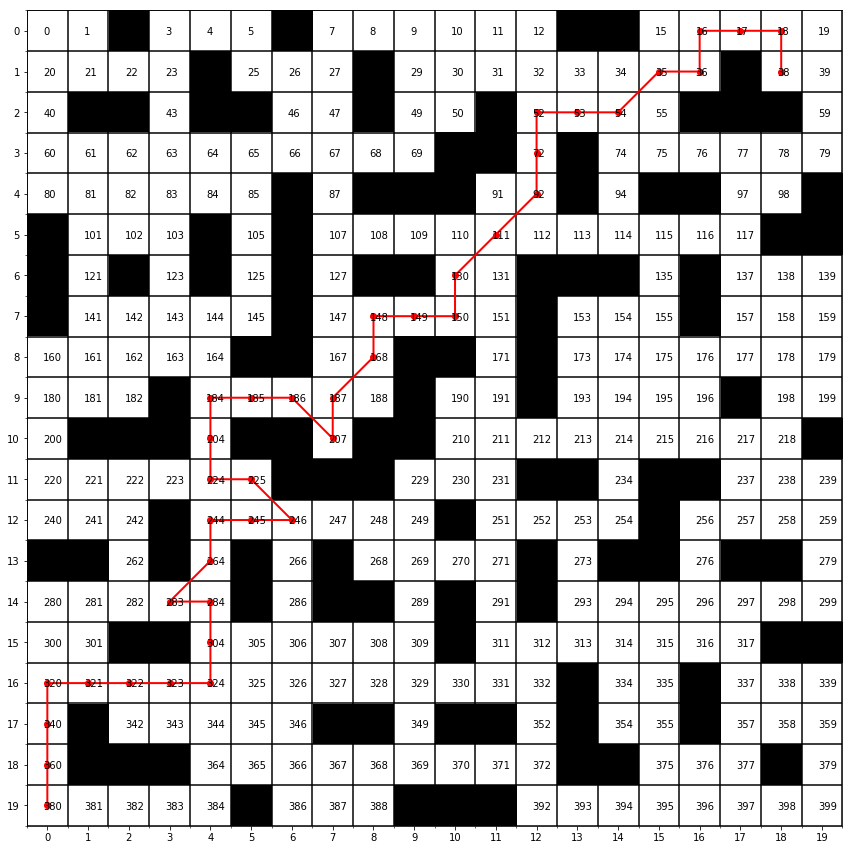

In [9]:
a.show()

在G1图上生成一个路径，看看各个主要的算子在干什么

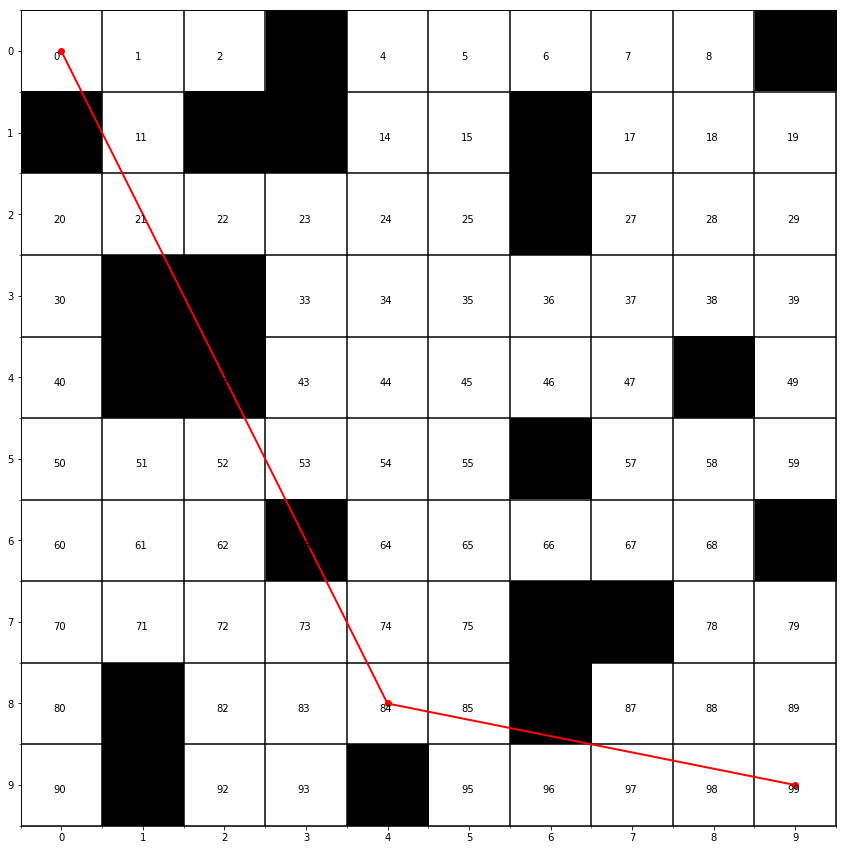

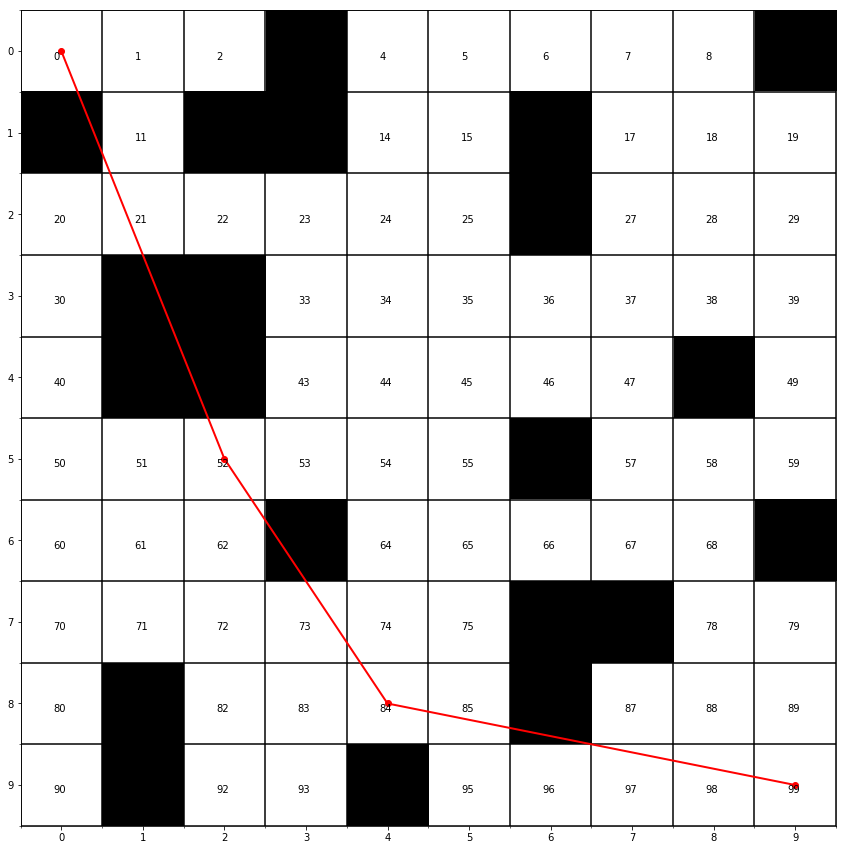

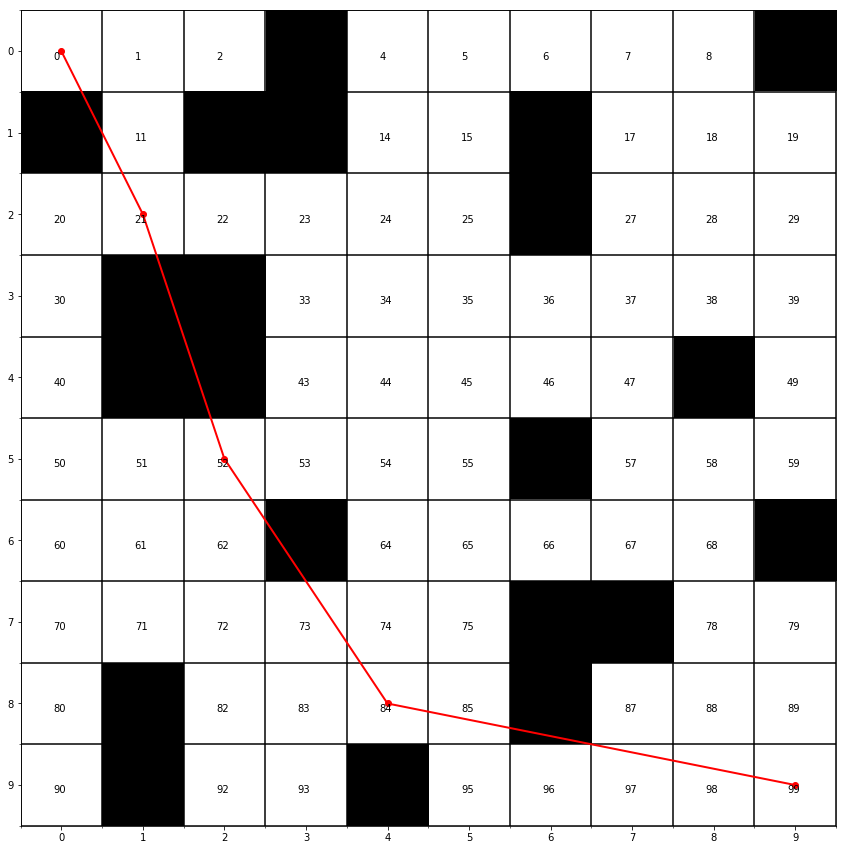

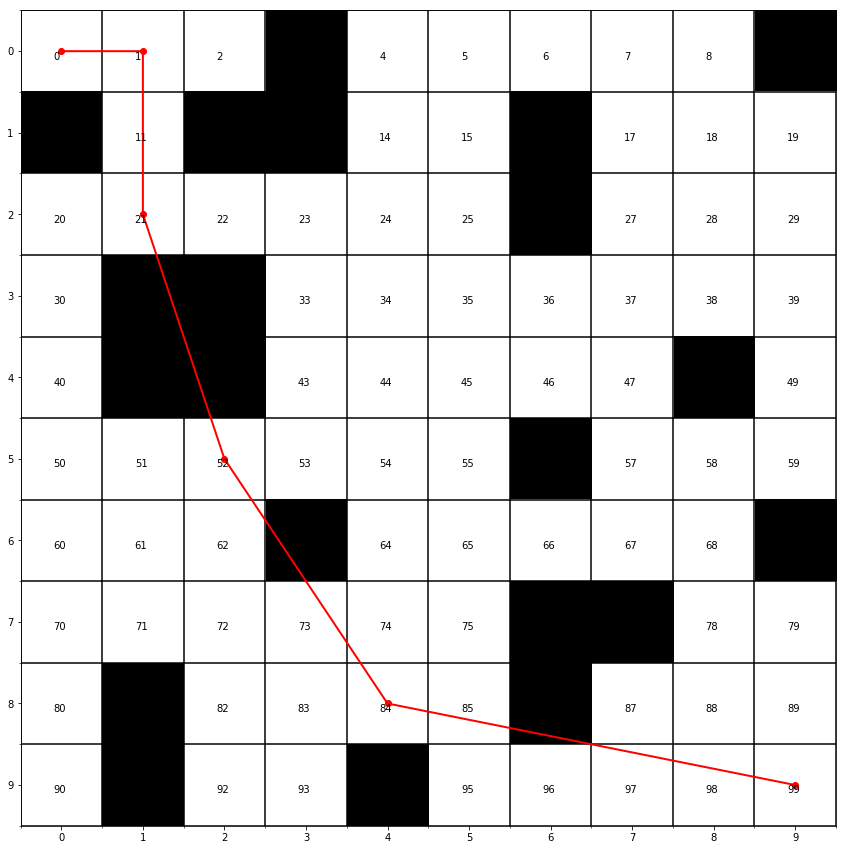

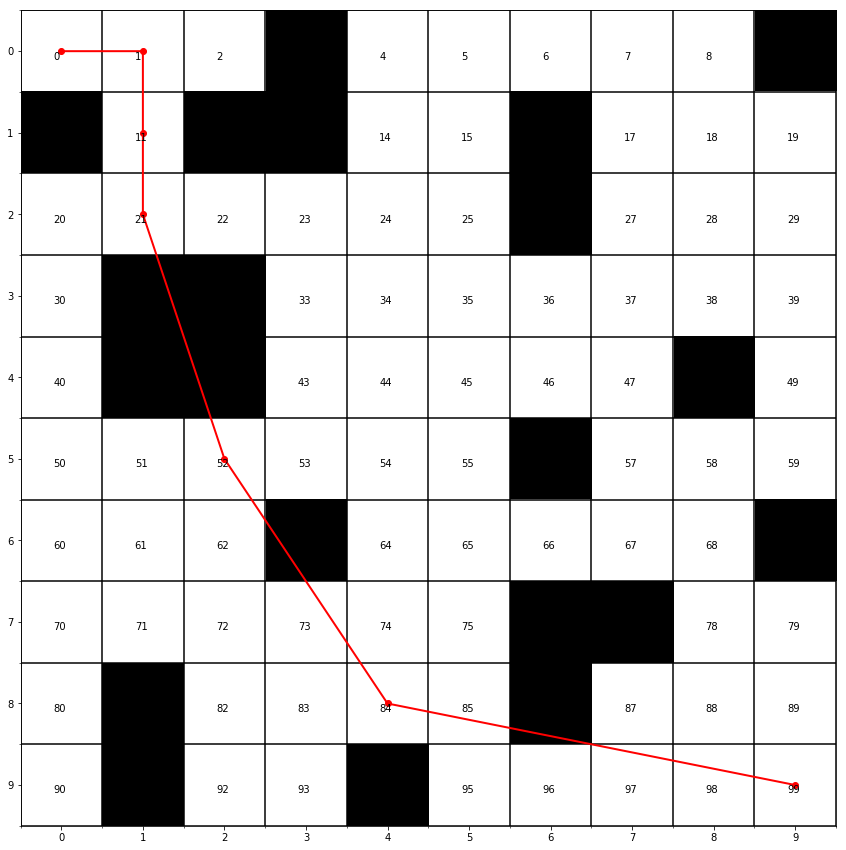

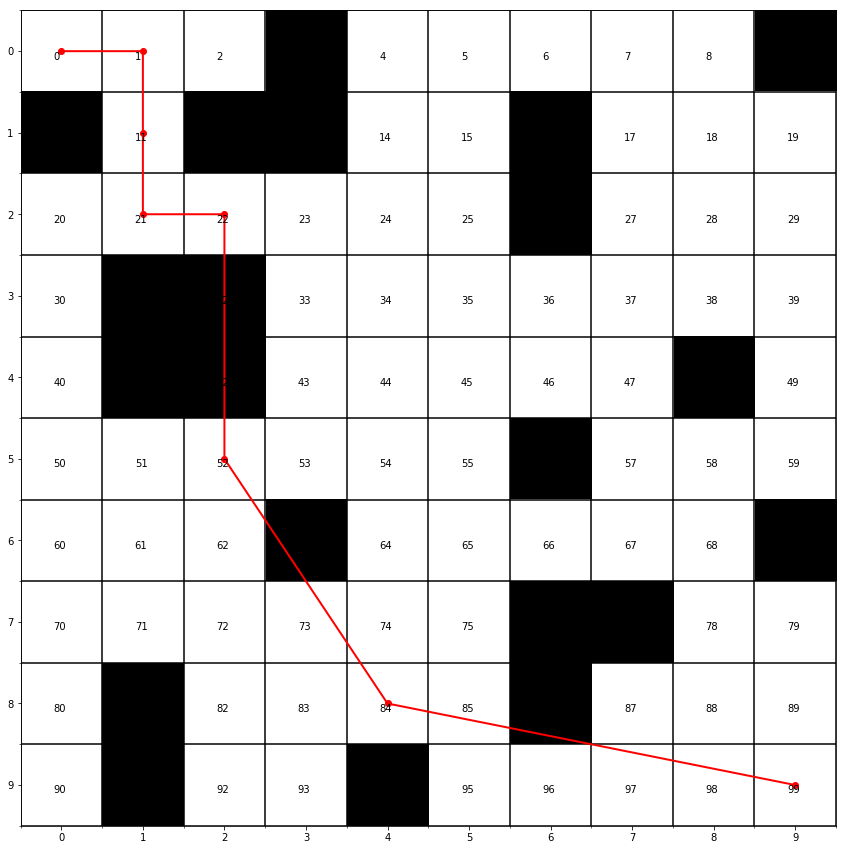

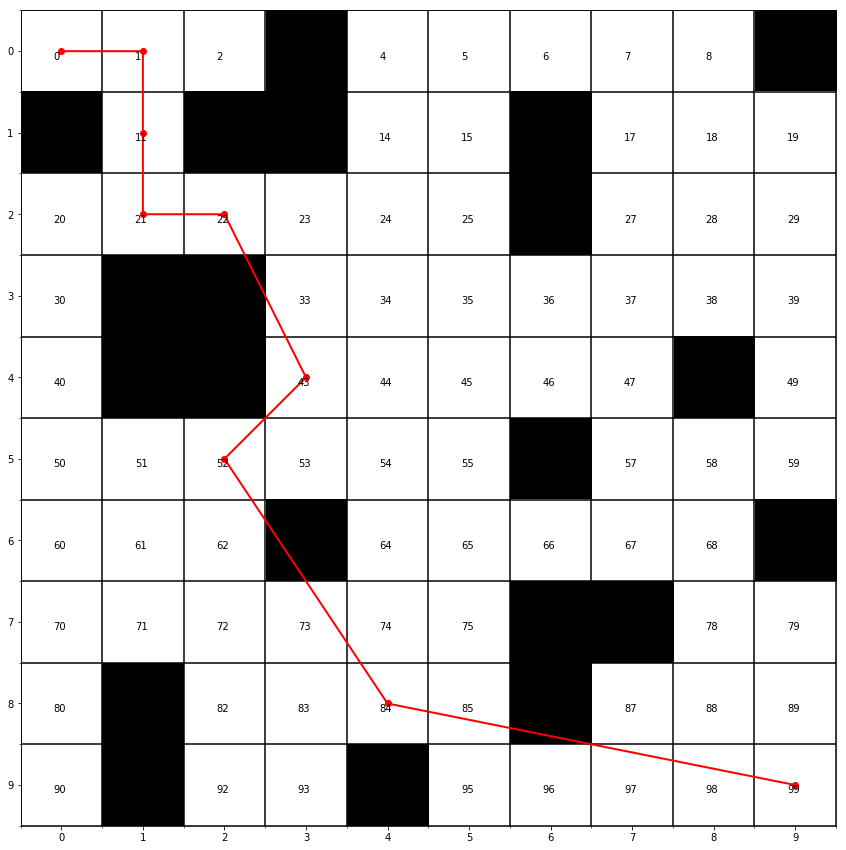

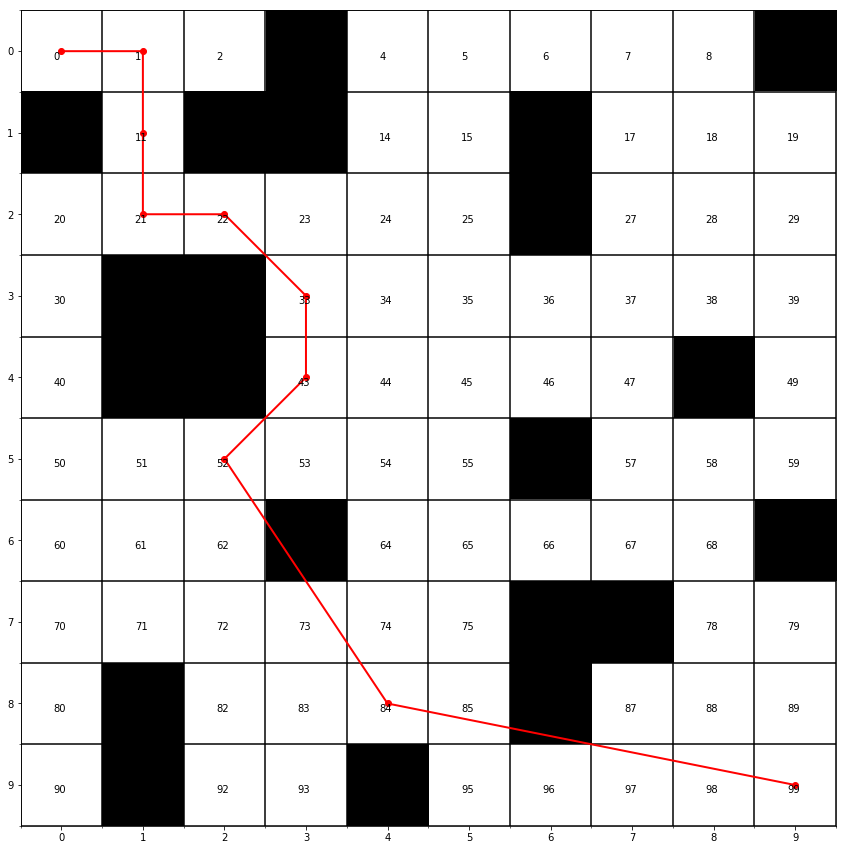

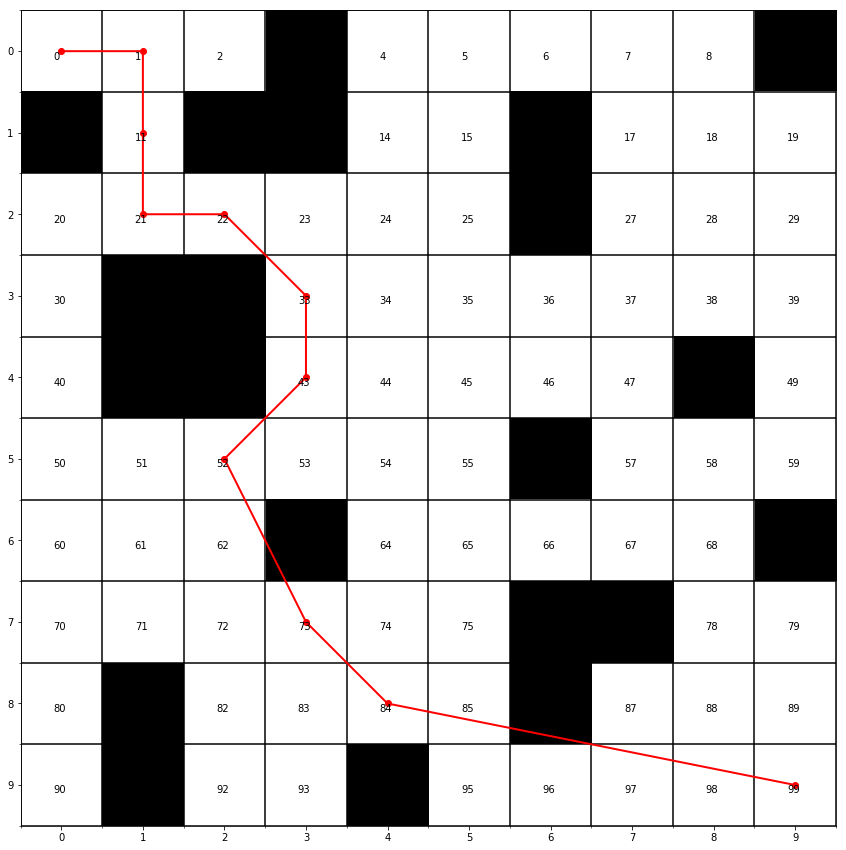

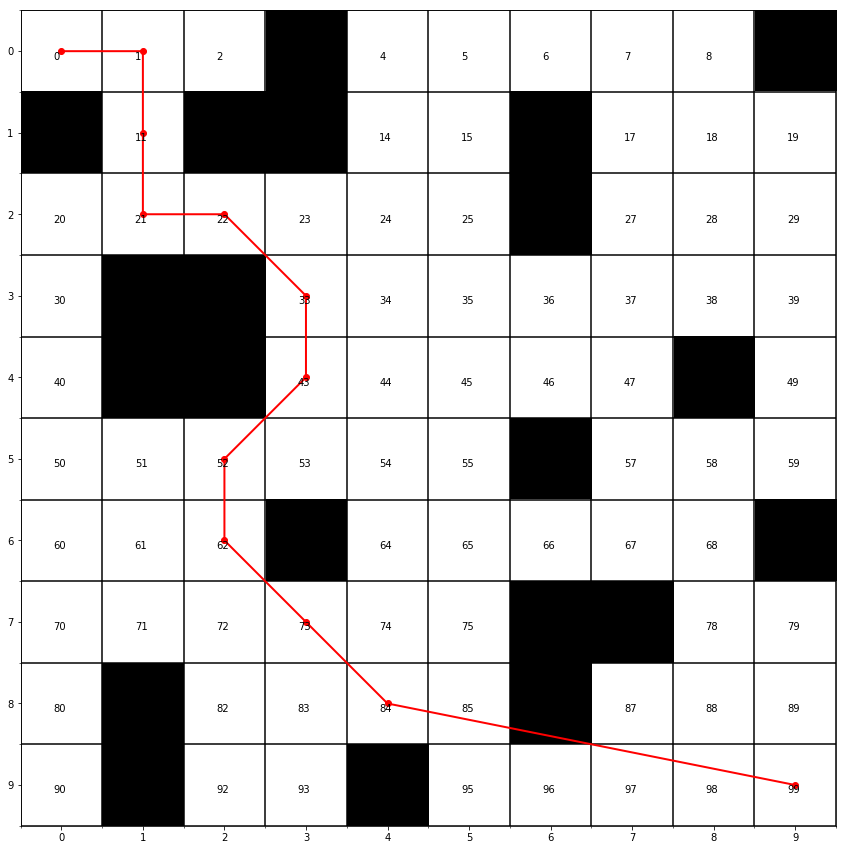

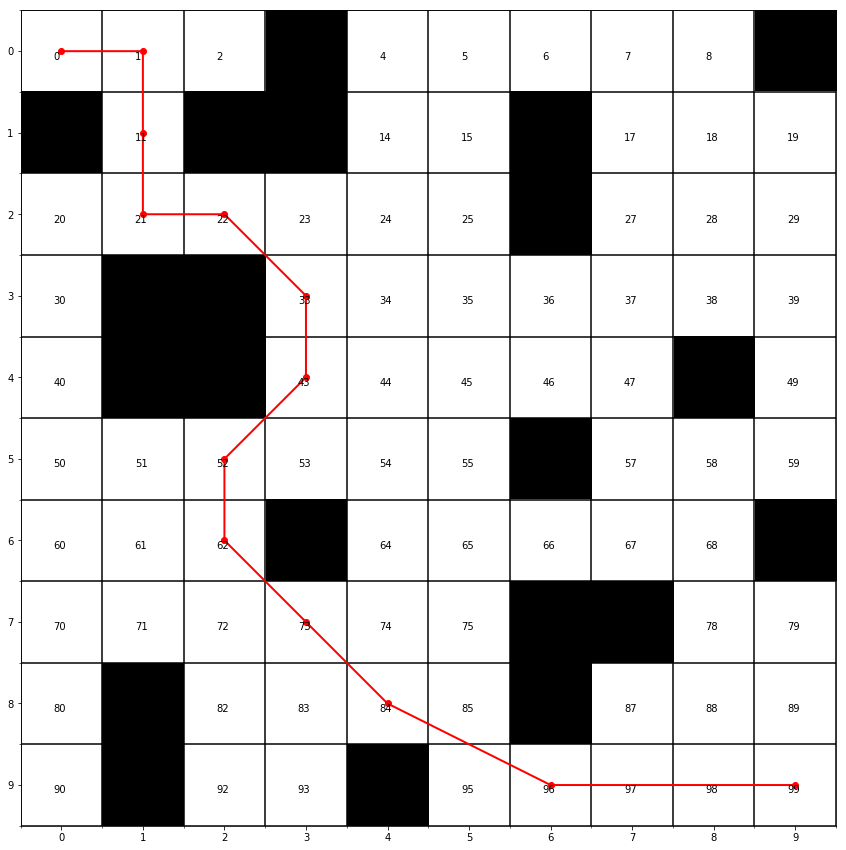

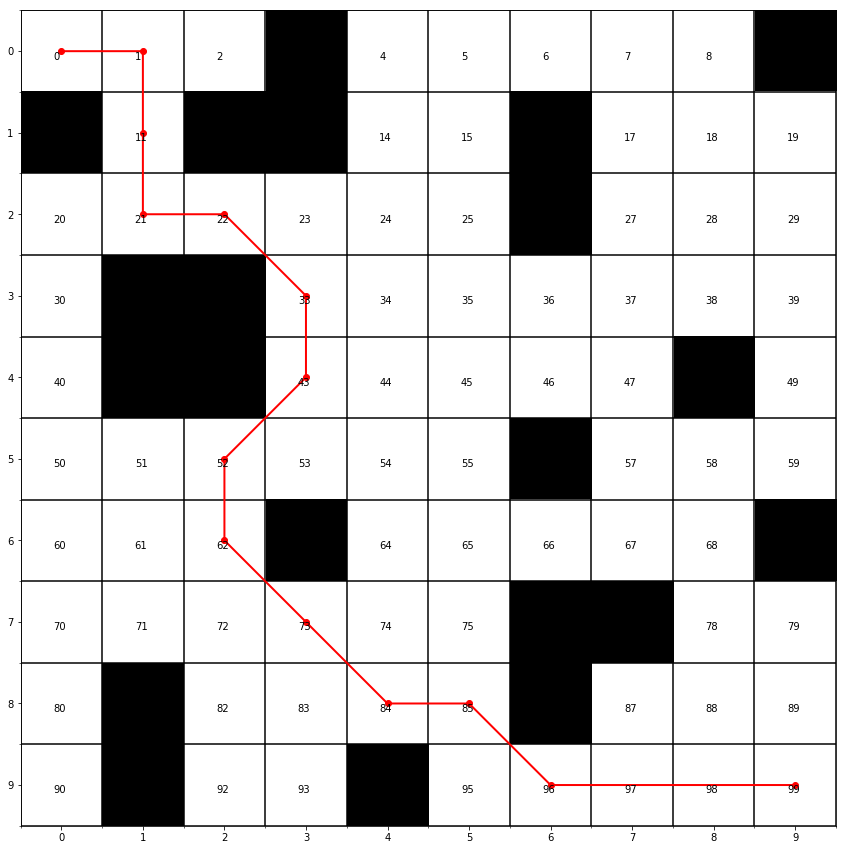

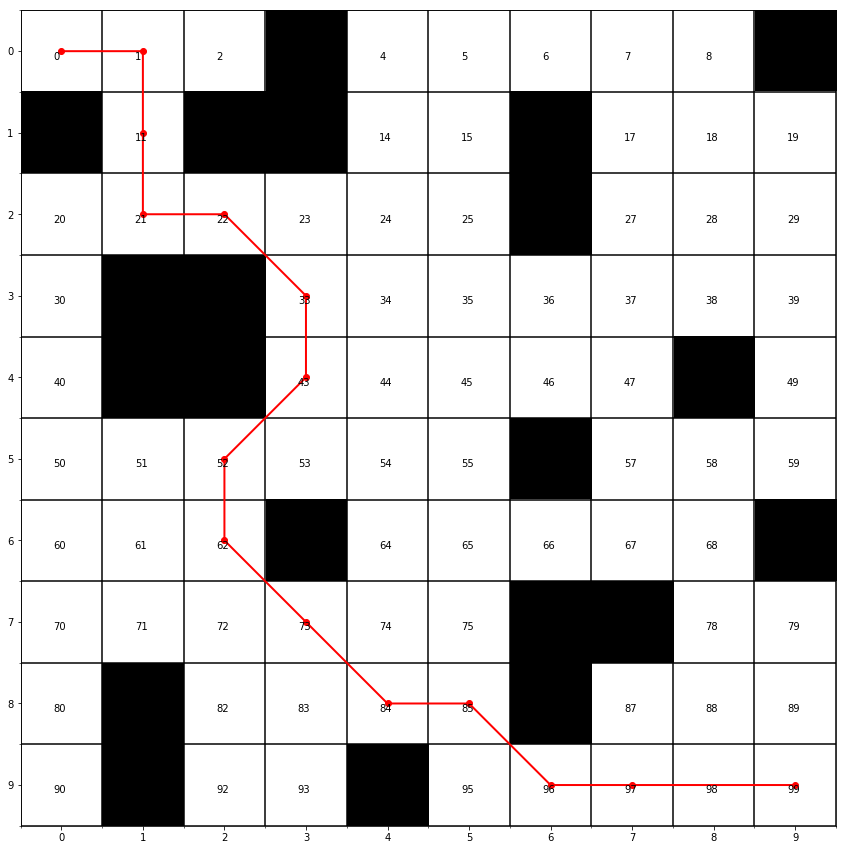

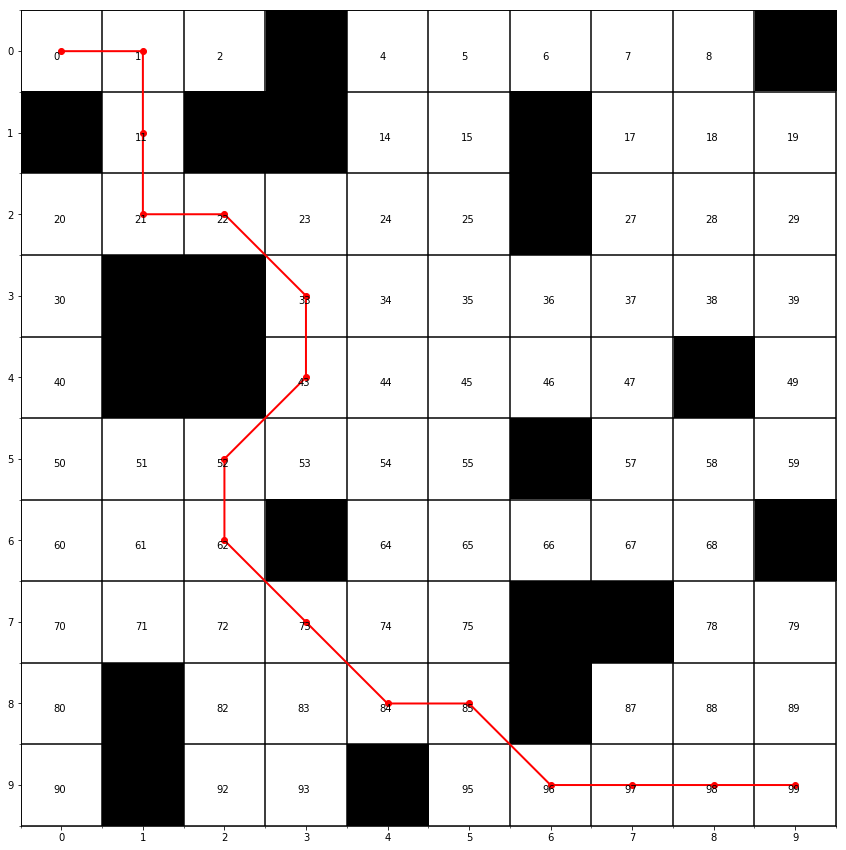

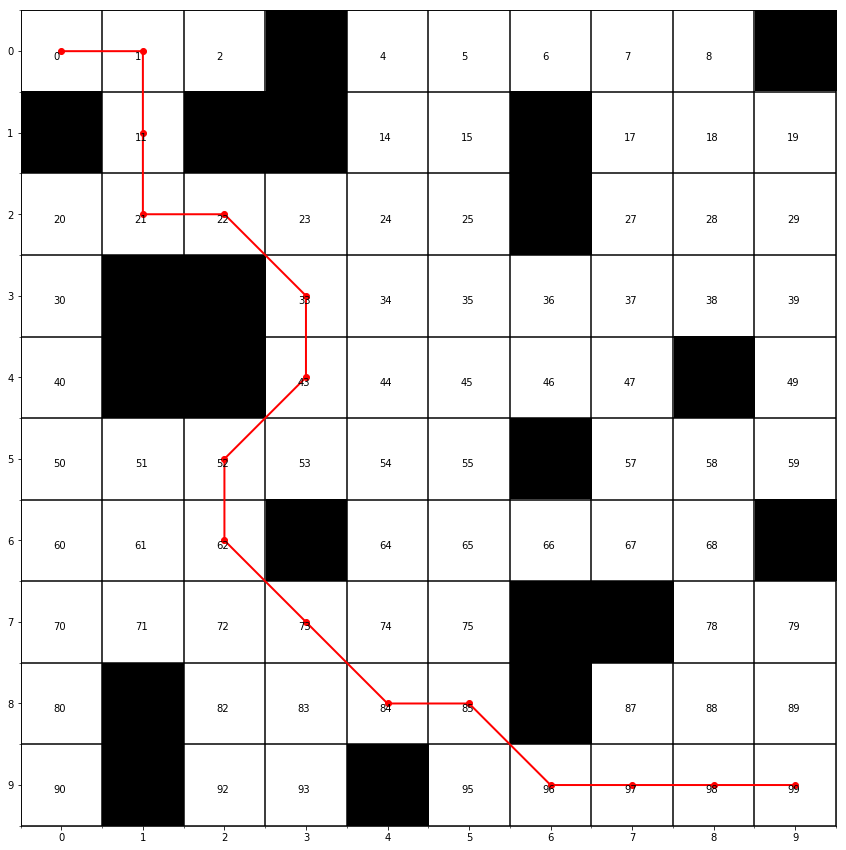

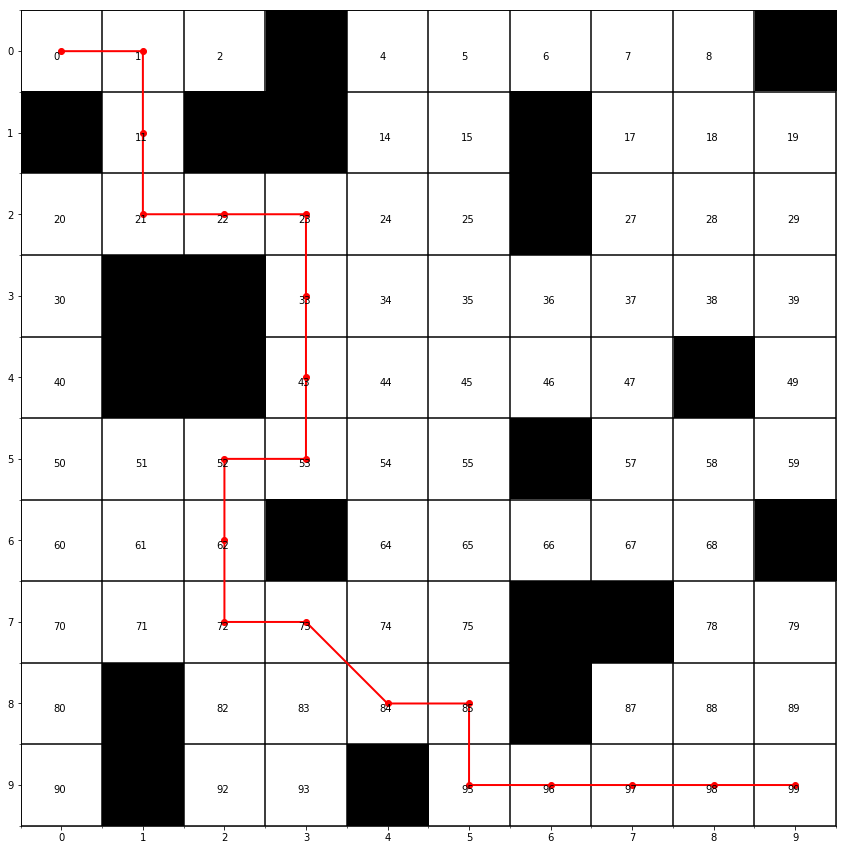

In [22]:
b = Individual(G1, 0, 99, 3)

我认为，插入算子在此问题上最为有用

#### Population 类：

- 属性：
 + __grid： 所在网格
 + __individuals: 个体组成的数组
 + __pc: 交叉概率
 + __pm: 变异概率
 + __start: 起点
 + __end: 终点
 + __best_individual: 历代最优个体

In [25]:
class Population:
    __slots__=('__grid', '__individuals', '__pc', '__pm', '__start', '__end', '__best_individual')
    
    def __init__(self, grid, M, pc, pm, start, end, init_len=3):
        """
        M: size of the population
        grid: a Grid object
        pc: probability of crossover
        pm: probability of mutation
        """
        self.__grid = grid
        
        ppl = []
        for i in range(M):
            ppl.append(Individual(grid, start, end, init_len))
        
        self.__individuals = ppl
        self.__pc = pc
        self.__pm = pm
        
        self.__best_individual = deepcopy(ppl[self.best_individual_idx(ppl)])
    
    @property
    def M(self):
        return len(self.__individuals)
    
    @property
    def pc(self):
        return self.__pc
    
    @property
    def pm(self):
        return self.__pm
    
    @property
    def best_individual(self):
        return self.__best_individual
    
    @property
    def individuals(self):
        return self.__individuals
    
    def best_individual_idx(self, ppl):
        fitValues = [individual.fitness_func() for individual in ppl]
        d = dict(zip(np.arange(len(ppl)), fitValues))
        idx = min(d, key=d.get)
        return idx
    
    def worst_individual_idx(self, ppl):
        fitValues = [individual.fitness_func() for individual in ppl]
        d = dict(zip(np.arange(len(ppl)), fitValues))
        idx = max(d, key=d.get)
        return idx
    
    def step(self):
        """
        """        
        # selection
        new_ppl = []
        for i in range(self.M):
            new_ppl.append(self.__tournament_selection())
        
        # crossover
        l = np.arange(self.M)
        np.random.shuffle(l)
        g1 = l[:int(self.M/2)]
        g2 = l[int(self.M/2):]
        for i, j in zip(g1, g2):
            if np.random.binomial(1,self.pc):
                a = new_ppl[i]
                b = new_ppl[j]
                a.crossover(b)
        
        # mutation
        for idx in range(self.M):
            if np.random.binomial(1,self.pm):
                new_ppl[idx].mutation(1,1,1)
                
        best_idx = self.best_individual_idx(new_ppl)
        worst_idx = self.worst_individual_idx(new_ppl)
        
        # save best indivdual ever
        if new_ppl[best_idx].fitness_func() < self.__best_individual.fitness_func():
            self.__best_individual = deepcopy(new_ppl[best_idx])
        else:
            new_ppl[worst_idx] = deepcopy(self.__best_individual)
        
        self.__individuals = deepcopy(new_ppl)
        
    
    def __tournament_selection(self, elementNum=2):
        """
        """
        GameGroup_idxs = np.random.choice(np.arange(self.M), elementNum)
        GameGroup_fitValues = [self.__individuals[idx].fitness_func() for idx in GameGroup_idxs]
        d = dict(zip(GameGroup_idxs, GameGroup_fitValues))
        idx = min(d, key=d.get)
        return self.__individuals[idx]

#### GA_Vieweer 类：

运行群体类若干代，并记录结果，保存下来，输出分析图表

In [39]:
class GA_Viewer:
    
    def __init__(self, ppl, num):
        self.__ppl = ppl
        self.__num = num
        
        fit = []
        for i in range(self.__num):
            fit.append([ind.fitness_func() for ind in self.__ppl.individuals])
            # self.__ppl.best_individual.show()
            # plt.savefig('animate_'+str(i))
            # plt.close()
            self.__ppl.step()
        
        fit.append([ind.fitness_func() for ind in self.__ppl.individuals])
        # self.__ppl.best_individual.show()
        # plt.savefig('animate_'+ str(self.__num))
        # plt.close()
        
        self.__fit = fit
        #images = []
        #path = '/Users/adminXTS/Desktop/前沿数学讨论/Pre1/'
        #filenames = sorted(fn for fn in os.listdir(path) if fn.endswith('.png'))
        #for filename in filenames:
            #images.append(imageio.imread(path + filename))
        #imageio.mimsave('animation.gif', images, duration=0.5, loop=1)  # duration 每帧间隔时间，loop 循环次数
        
        
    def display_solution(self):
        self.__ppl.best_individual.information_report()
        self.__ppl.best_individual.show()
        
    def evoluation_plot(self):
        x = np.arange(self.__num + 1)
        y_max = [min(i) for i in self.__fit]
        y_avg = [sum(i)/len(i) for i in self.__fit]
        plt.plot(x, y_max)
        plt.xlabel('Geneartion')
        plt.ylabel('Fitness Function Value of Individuals')
        plt.plot(x, y_avg)
        plt.legend(['Best','Average'])
        plt.xlabel('Geneartion')

在G1网络图上，生成一个群体ppl，群体数量为10，交叉概率设置为0.8， 变异概率设置为0.3， 起点为0，终点为99

Path:  0-> 1-> 11-> 21-> 22-> 23-> 34-> 35-> 46-> 47-> 57-> 68-> 78-> 88-> 99
n:  15
Distance:   15.6568542495
Fitness function:  15.6568542495


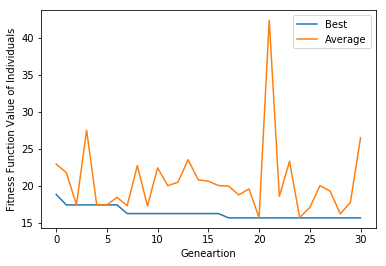

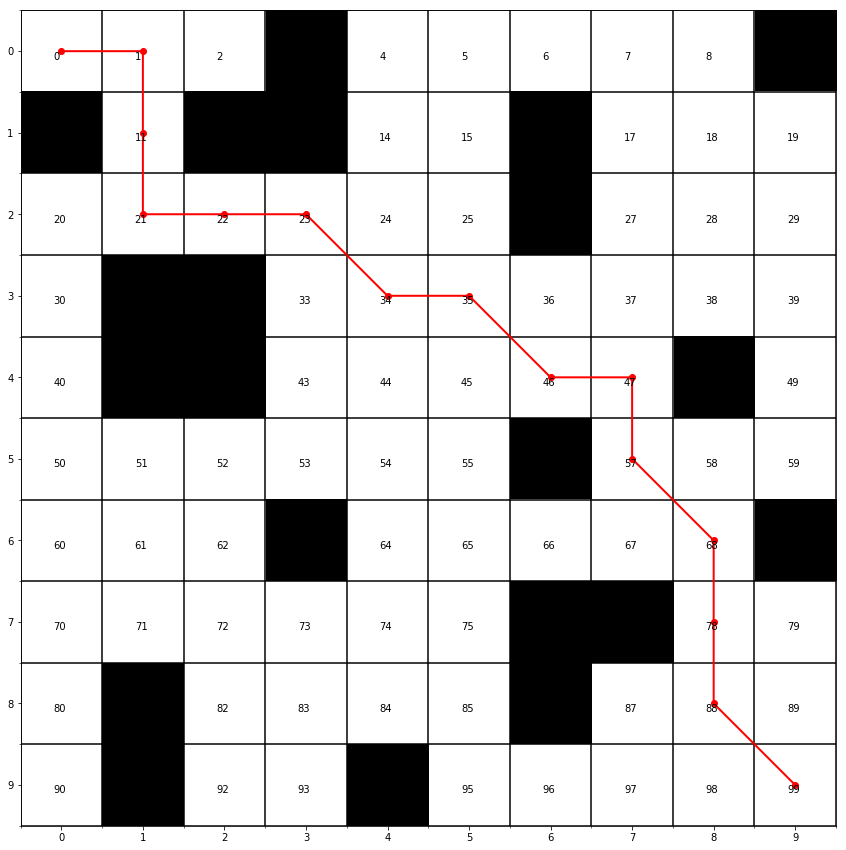

In [40]:
ppl = Population(G1, M=10, pc=0.8, pm=0.3, start=0, end=99)
viewer = GA_Viewer(ppl, num=30)
viewer.evoluation_plot()
viewer.display_solution()

结果很奇怪，初代群体就能够生成最优解了，可能原因是因为群体大小较大？网格比较简单？

在G2网络图上，生成一个群体ppl，群体数量为50，交叉概率设置为0.8， 变异概率设置为0.3， 起点为38，终点为380

In [45]:
ppl = Population(G2, M=50, pc=0.8, pm=0.3, start=38, end=380)
viewer = GA_Viewer(ppl, num=30)

画出适应度函数随着代数变化的图片

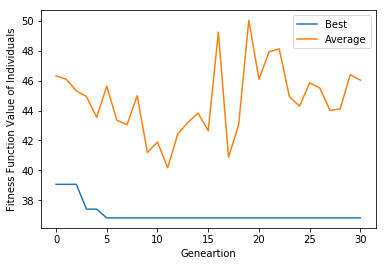

In [46]:
viewer.evoluation_plot()

这种结果就比较奇怪，主要原因在与，初始群体很好的找到了最优解

输出最优个体的信息

Path:  38-> 18-> 17-> 16-> 36-> 35-> 55-> 54-> 53-> 52-> 72-> 92-> 111-> 110-> 109-> 108-> 107-> 127-> 147-> 167-> 187-> 186-> 185-> 184-> 204-> 224-> 223-> 222-> 242-> 262-> 282-> 281-> 301-> 320-> 340-> 360-> 380
n:  37
Distance:   36.8284271247
Fitness function:  36.8284271247


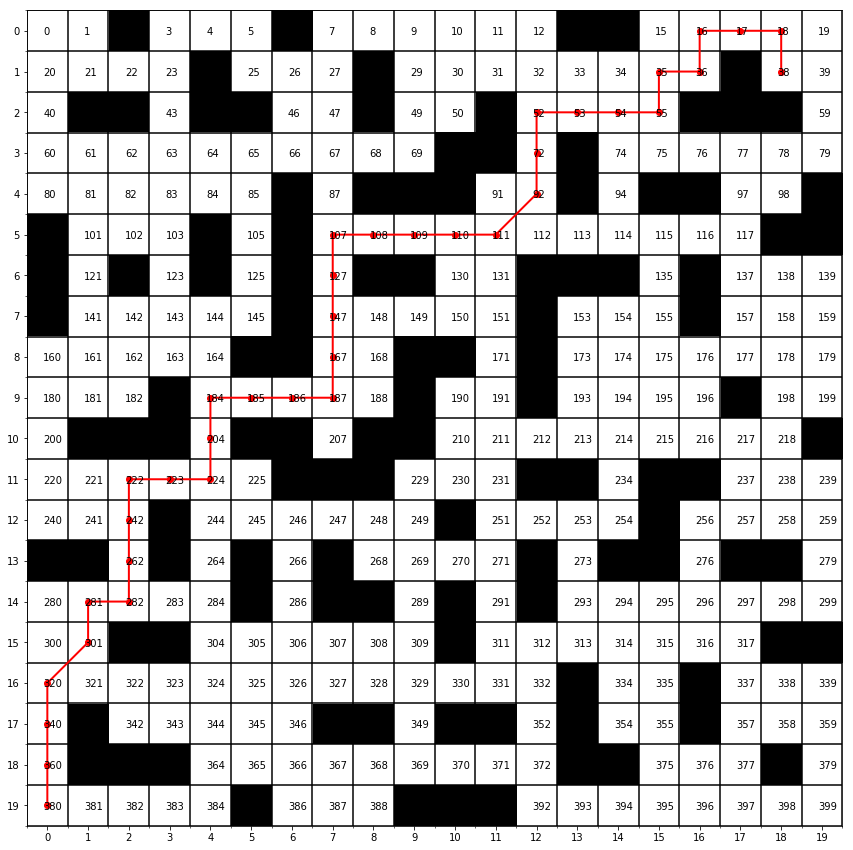

In [47]:
viewer.display_solution()

再尝试运行一次，看看结果

Path:  38-> 18-> 17-> 16-> 36-> 35-> 34-> 53-> 52-> 72-> 92-> 91-> 111-> 110-> 130-> 150-> 149-> 148-> 167-> 187-> 186-> 185-> 184-> 204-> 224-> 223-> 242-> 262-> 282-> 281-> 301-> 320-> 340-> 360-> 380
n:  35
Distance:   35.6568542495
Fitness function:  35.6568542495


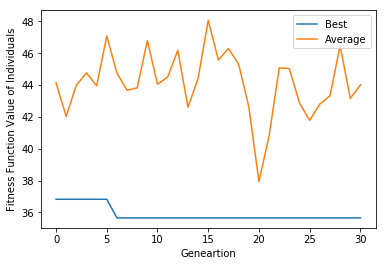

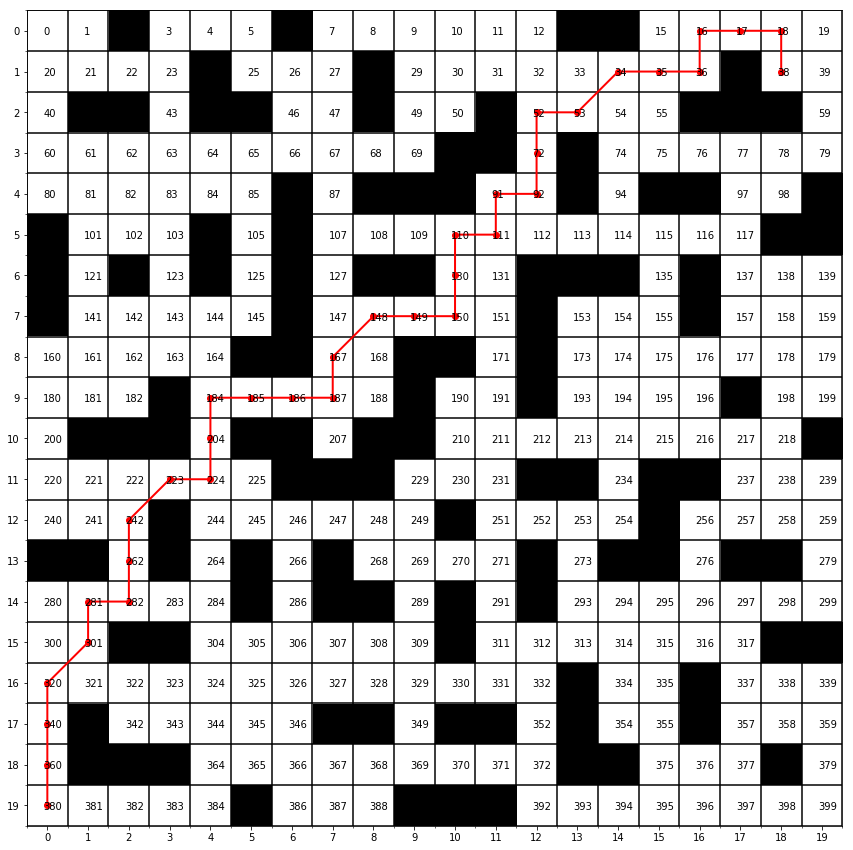

In [48]:
ppl = Population(G2, M=50, pc=0.8, pm=0.3, start=38, end=380)
viewer = GA_Viewer(ppl, num=30)
viewer.evoluation_plot()
viewer.display_solution()

找到了另外一条还不错的路径

局部路径的优化还有点问题，路径应该尽可能地走斜边